In [1]:
import numpy as np
import torch
import gpytorch
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.distributions import MultivariateNormal
import matplotlib.pyplot as plt

## Gaussian Process Regression

A data set $\left (X, \mathbf{y} \right ) = \left \{ (x_i, y_i), x_i \in \mathbb{R}^d, y_i \in \mathbb{R} \right \}_{i = 1}^N$ is given.  

Assumption:
$$
y = f(x) + \varepsilon,
$$
where $f(x)$ is a Gaussian Processes and $\varepsilon \sim \mathcal{N}(0, \sigma_n^2)$ is a Gaussian noise .

Now, given a new data point $x^*$, $y^*$ can be predicted with
$$
y_* | X, \mathbf{y}, x_* \sim \mathcal{N}(m(x_*), \sigma(x_*)),
$$
with predictive mean and variance given by
$$
m(x_*) = \mathbf{k}^T \mathbf{K}_y^{-1} \mathbf{y} = \sum_{i = 1}^N \alpha_i k(x_*, x_i),
$$
$$
\sigma^2(x_*) = k(x_*, x_*) - \mathbf{k}^T\mathbf{K}_y^{-1}\mathbf{k},
$$
where
$$
\mathbf{k} = \left ( k(x_*, x_1), \ldots, k(x_*, x_N) \right )^T
$$
$$
\mathbf{K}_y = \|k(x_i, x_j)\|_{i, j = 1}^N + \sigma_n^2 \mathbf{I}
$$

The most commonly used kernel is the RBF kernel  $k(x, y) = \exp\left ( -\dfrac{\|x - y\|^2}{2l^2}\right )$,
where $l$ is a `lengthscale`.  There is usually a multiplicative constant in front which controls the amplitude, and can be accessed with `ScaleKernel(RBFKernel())`

In [2]:
def branin(x, y):
    a = 1
    b = 5.1 / (4*np.pi**2)
    c = 5 / np.pi
    r = 6
    s = 10
    t = 1 / (8*np.pi)
    return a*(y - b*x**2 + c*x - r)**2 + s*(1-t)*np.cos(x) + s

def objective_function(x):
    # Objective function with a non-differentiable point at x = 0
    return torch.abs(x - 2)  # Shifted to have a minimum at x = 2


The `GPModel` class is the thing that calculates the Gaussian process. If you pass it the training set, it calculates the prior distribution. If you pass it some new points, it calculates the conditional distribution given by n
$$
y_* | X, \mathbf{y}, x_* \sim \mathcal{N}(m(x_*), \sigma(x_*)),
$$

In [3]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

    def predict(self, train_x):
            self.eval()
            with torch.no_grad():
                pred = self(train_x)
                return self.likelihood(pred)
                

## train on training set

In [4]:
BRANIN=False
if BRANIN:
    train_x = torch.rand(5,2,dtype=torch.float64)
    def calc_output(train_x):
        return torch.tensor([branin(x[0], x[1]) for x in train_x],dtype=torch.float64).unsqueeze(-1)
    train_y = calc_output(train_x).reshape(-1)
else:

    train_x = torch.linspace(-5, 5, 5,dtype=torch.float64)
    train_y = objective_function(train_x)
    print(train_y)
    


tensor([7.0000, 4.5000, 2.0000, 0.5000, 3.0000], dtype=torch.float64)


## Define model and likelihood

In [5]:
# GP model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(train_x, train_y, likelihood)

In [6]:
model.train_inputs

(tensor([[-5.0000],
         [-2.5000],
         [ 0.0000],
         [ 2.5000],
         [ 5.0000]], dtype=torch.float64),)

In [7]:
model.train_inputs[0].numpy().ndim

2

In [8]:
model.train_inputs[0].numpy().shape

(5, 1)

In [9]:
model.train_targets

tensor([7.0000, 4.5000, 2.0000, 0.5000, 3.0000], dtype=torch.float64)

In [10]:
def plot_model(model):
    train_x = model.train_inputs[0].numpy()
    train_y = model.train_targets.numpy()
    if train_x.shape[1] == 1 or train_x.ndim ==1:
        x_star = torch.linspace(train_x.min(), train_x.max(), 200)
    else:
        x_star = torch.tensor(np.random.rand(train_x.shape[0],train_x.shape[1]),)
    model.eval()
    predictive_distribution = model.predict(x_star)
    lower, upper = predictive_distribution.confidence_region()
    pred = predictive_distribution.mean.numpy()

    
    plt.plot(x_star.numpy(), pred, label='Mean Prediction')
    plt.fill_between(x_star.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    plt.plot(train_x, train_y, 'k*', label='Observed Data')
    plt.legend()
    plt.show()

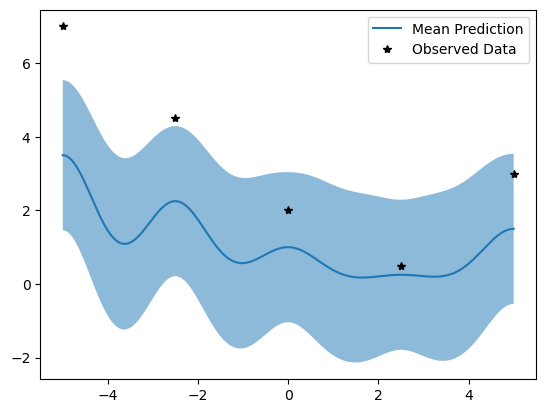

In [11]:
plot_model(model)

In [12]:
def print_parameters(model):
    state_dict = model.state_dict()
    for param_name, param_tensor in state_dict.items():
        print(param_name, param_tensor)

In [13]:
print_parameters(model)

likelihood.noise_covar.raw_noise tensor([0.])
likelihood.noise_covar.raw_noise_constraint.lower_bound tensor(1.0000e-04)
likelihood.noise_covar.raw_noise_constraint.upper_bound tensor(inf)
mean_module.raw_constant tensor(0.)
covar_module.raw_outputscale tensor(0.)
covar_module.base_kernel.raw_lengthscale tensor([[0.]])
covar_module.base_kernel.raw_lengthscale_constraint.lower_bound tensor(0.)
covar_module.base_kernel.raw_lengthscale_constraint.upper_bound tensor(inf)
covar_module.raw_outputscale_constraint.lower_bound tensor(0.)
covar_module.raw_outputscale_constraint.upper_bound tensor(inf)


## Train GP model

In [14]:
def train_model(model, train_x, train_y, n_epochs, print_=False):
    # Use the Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    
    # Optimize the model
    
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        output = model(train_x)
        loss = - mll(output, train_y)
        if print_:
            print(f'epoch {epoch}, Loss = {loss}')
        loss.backward()
        optimizer.step()

In [15]:
train_model(model, train_x, train_y, 35,print_=True)

/usr/local/lib/python3.10/dist-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


epoch 0, Loss = 2.9186248664651373
epoch 1, Loss = 2.4692474630995656
epoch 2, Loss = 2.071762694993134
epoch 3, Loss = 1.730986044923554
epoch 4, Loss = 1.4534991288783161
epoch 5, Loss = 1.248019804050955
epoch 6, Loss = 1.1249891103951974
epoch 7, Loss = 1.0924687803624795
epoch 8, Loss = 1.1352459346017638
epoch 9, Loss = 1.1984377110996791
epoch 10, Loss = 1.24326776485874
epoch 11, Loss = 1.2587606980241943
epoch 12, Loss = 1.2477141740532725
epoch 13, Loss = 1.2189690288572959
epoch 14, Loss = 1.1821510180342218
epoch 15, Loss = 1.1446398434922787
epoch 16, Loss = 1.1107790757750529
epoch 17, Loss = 1.082522912552595
epoch 18, Loss = 1.06045142870695
epoch 19, Loss = 1.0444824362889344
epoch 20, Loss = 1.0341693489303094
epoch 21, Loss = 1.0287661225339446
epoch 22, Loss = 1.0272487113444602
epoch 23, Loss = 1.028385881465216
epoch 24, Loss = 1.030869997279892
epoch 25, Loss = 1.0334766244113431
epoch 26, Loss = 1.0352138544562541
epoch 27, Loss = 1.0354279610183028
epoch 28, Lo

## observe that the GP model and likelihood parameters have been optimized

In [16]:
print_parameters(model)

likelihood.noise_covar.raw_noise tensor([0.])
likelihood.noise_covar.raw_noise_constraint.lower_bound tensor(1.0000e-04)
likelihood.noise_covar.raw_noise_constraint.upper_bound tensor(inf)
mean_module.raw_constant tensor(0.3587)
covar_module.raw_outputscale tensor(0.9246)
covar_module.base_kernel.raw_lengthscale tensor([[-0.4343]])
covar_module.base_kernel.raw_lengthscale_constraint.lower_bound tensor(0.)
covar_module.base_kernel.raw_lengthscale_constraint.upper_bound tensor(inf)
covar_module.raw_outputscale_constraint.lower_bound tensor(0.)
covar_module.raw_outputscale_constraint.upper_bound tensor(inf)


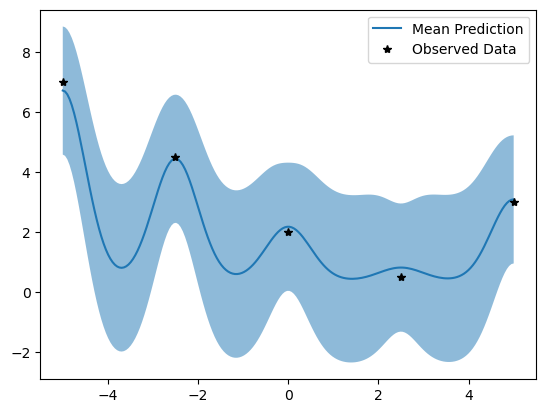

In [17]:
plot_model(model)

## Expected Improvement

$$\operatorname{EI}(x)=\mathbb{E}\left[\max \left(f_{\text {best }}-f(x), 0\right)\right]$$

Assuming $f(x) \sim \mathcal{N}\left(\mu(x), \sigma(x)^2\right)$, the EI can be written as

$$\mathrm{EI}(x)=\left(\mu(x)-f_{\text {best }}-\xi\right) \Phi(Z)+\sigma(x) \phi(Z)$$

where

- $$\begin{array}{l}
Z=\frac{\mu(x)-f_{\text {bost }}-\xi}{\sigma(x)} \text { if } \sigma(x)>0 \\
Z=0 \text { if } \sigma(x)=0
\end{array}$$

- $\Phi$ is the CDF of the standard normal distribution, $\phi(x)$ is the PDF of the standard normal  distribution

- $\xi$ is a small non-negative number (often set to zero) to introduce a trade-off between exploitation and exploration. **the larger the $\xi$ the more exploration** 

In [18]:
def expected_improvement(model, observed_y, candidate_set):
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = model.predict(candidate_set)
        best_f = observed_y.min()
        
        mean = observed_pred.mean
        sigma = observed_pred.variance.sqrt()
        gamma = (best_f - mean) / sigma
        ei = sigma * (gamma * torch.distributions.Normal(0, 1).cdf(gamma) + torch.distributions.Normal(0, 1).log_prob(gamma).exp())
    return ei


## Bayesian Optimization Algorithm
1. Construct a regression model $\hat{f}(x)$ of a function $f(x)$ using the sample $D = \{(x_i, f(x_i))\}_{i = 1}^n$
2. Select a new point that maximize an acquisition function
$$
x_{new} = \arg\max\limits_x a(x)
$$
3. Calculate $f(x_{new})$ at the new point.
4. Add the pair $(x_{new}, f(x_{new}))$ to the sample $D$.
5. Update the model $\hat{f}(x)$ and go to step 2.

In [19]:
def BayesOpt(model, train_x, train_y, n_epochs, retrain_gp=False,print_=False):
    # Use the Adam optimizer
    likelihood = gpytorch.likelihoods.GaussianLikelihood()


    for epoch in range(n_epochs):
        model.eval()
        likelihood.eval()
        x_candidates = torch.linspace(-5,5,100)
        ei = expected_improvement(model, train_y, x_candidates)
        ei_argmax = ei.argmax()
        next_x = x_candidates[ei_argmax]
        next_y = objective_function(next_x)
        train_x = torch.cat([train_x, next_x.unsqueeze(-1)])
        next_y = torch.tensor([next_y])

        print(f'epoch {epoch} next_x = {next_x}, next_y = {next_y}')
        train_y = torch.cat([train_y, next_y])

        # retrain model with updated data
        if retrain_gp:
            train_model(model, train_x, train_y, n_epochs, print_=print_)
        model.set_train_data(inputs=train_x, targets=train_y, strict=False)
        
        

## perform Bayesian optimization without retraing model with the updated data

In [20]:
BayesOpt(model, train_x, train_y, 25)

epoch 0 next_x = 1.3636364936828613, next_y = tensor([0.6364])
epoch 1 next_x = 3.4848484992980957, next_y = tensor([1.4848])
epoch 2 next_x = -1.1616162061691284, next_y = tensor([3.1616])
epoch 3 next_x = 1.9696969985961914, next_y = tensor([0.0303])
epoch 4 next_x = 1.9696969985961914, next_y = tensor([0.0303])
epoch 5 next_x = 1.9696969985961914, next_y = tensor([0.0303])
epoch 6 next_x = 1.9696969985961914, next_y = tensor([0.0303])
epoch 7 next_x = 2.070707082748413, next_y = tensor([0.0707])
epoch 8 next_x = 1.9696969985961914, next_y = tensor([0.0303])
epoch 9 next_x = 1.9696969985961914, next_y = tensor([0.0303])
epoch 10 next_x = 1.9696969985961914, next_y = tensor([0.0303])
epoch 11 next_x = 1.9696969985961914, next_y = tensor([0.0303])
epoch 12 next_x = 1.9696969985961914, next_y = tensor([0.0303])
epoch 13 next_x = 1.9696969985961914, next_y = tensor([0.0303])
epoch 14 next_x = 1.9696969985961914, next_y = tensor([0.0303])
epoch 15 next_x = 1.9696969985961914, next_y = ten

In [21]:
train_x.shape

torch.Size([5])

In [22]:
model.train_inputs[0].numpy().shape

(30, 1)

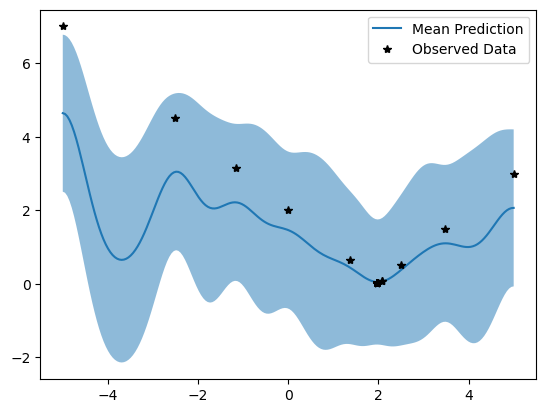

In [23]:
plot_model(model)

In [24]:
def get_best_parameter(model):
    train_x = model.train_inputs[0].numpy()
    train_y = model.train_targets.numpy()
    best_param_observed_param = train_x[train_y.argmin()]
    print(f'best parameter = {best_param_observed_param}')
    return best_param_observed_param

In [25]:
get_best_parameter(model)

best parameter = [1.969697]


array([1.969697])

## Perform Bayeian Optimization with retraing model with the updated data

In [27]:
BayesOpt(model, train_x, train_y, 25, retrain_gp=True,print_=False)

epoch 0 next_x = 1.9696969985961914, next_y = tensor([0.0303])
epoch 1 next_x = 1.464646577835083, next_y = tensor([0.5354])
epoch 2 next_x = 2.1717171669006348, next_y = tensor([0.1717])
epoch 3 next_x = 2.1717171669006348, next_y = tensor([0.1717])
epoch 4 next_x = 2.070707082748413, next_y = tensor([0.0707])
epoch 5 next_x = 2.070707082748413, next_y = tensor([0.0707])
epoch 6 next_x = 2.070707082748413, next_y = tensor([0.0707])
epoch 7 next_x = 2.070707082748413, next_y = tensor([0.0707])
epoch 8 next_x = 2.070707082748413, next_y = tensor([0.0707])
epoch 9 next_x = 2.070707082748413, next_y = tensor([0.0707])
epoch 10 next_x = 2.070707082748413, next_y = tensor([0.0707])
epoch 11 next_x = 2.070707082748413, next_y = tensor([0.0707])
epoch 12 next_x = 2.070707082748413, next_y = tensor([0.0707])
epoch 13 next_x = 1.9696969985961914, next_y = tensor([0.0303])
epoch 14 next_x = 1.9696969985961914, next_y = tensor([0.0303])
epoch 15 next_x = 3.1818182468414307, next_y = tensor([1.181

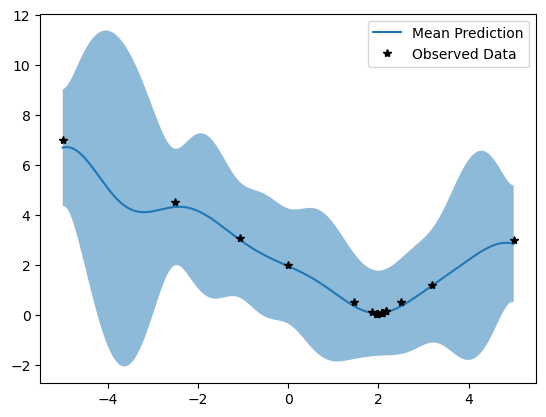

In [28]:
plot_model(model)

In [29]:
get_best_parameter(model)

best parameter = [1.969697]


array([1.969697])

In [30]:
model.train_inputs

(tensor([[-5.0000],
         [-2.5000],
         [ 0.0000],
         [ 2.5000],
         [ 5.0000],
         [ 1.9697],
         [ 1.4646],
         [ 2.1717],
         [ 2.1717],
         [ 2.0707],
         [ 2.0707],
         [ 2.0707],
         [ 2.0707],
         [ 2.0707],
         [ 2.0707],
         [ 2.0707],
         [ 2.0707],
         [ 2.0707],
         [ 1.9697],
         [ 1.9697],
         [ 3.1818],
         [ 1.9697],
         [ 1.9697],
         [ 1.9697],
         [ 1.9697],
         [ 1.9697],
         [-1.0606],
         [ 1.8687],
         [ 1.9697],
         [ 1.9697]], dtype=torch.float64),)

## save model


In [52]:
path = 'models/test_GP.pth'
torch.save(model.state_dict(), path)

## Refresh the kernel (as if opening a new notebook) and load model

In [53]:
import numpy as np
import torch
import gpytorch
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.distributions import MultivariateNormal
import matplotlib.pyplot as plt

In [54]:
def branin(x, y):
    a = 1
    b = 5.1 / (4*np.pi**2)
    c = 5 / np.pi
    r = 6
    s = 10
    t = 1 / (8*np.pi)
    return a*(y - b*x**2 + c*x - r)**2 + s*(1-t)*np.cos(x) + s

def objective_function(x):
    # Objective function with a non-differentiable point at x = 0
    return torch.abs(x - 2)  # Shifted to have a minimum at x = 2


In [55]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

    def predict(self, train_x):
            self.eval()
            with torch.no_grad():
                pred = self(train_x)
                return self.likelihood(pred)
                

In [56]:
BRANIN=False
if BRANIN:
    train_x = torch.rand(5,2)
    def calc_output(train_x):
        return torch.tensor([branin(x[0], x[1]) for x in train_x]).unsqueeze(-1)
    train_y = calc_output(train_x)
else:

    train_x = torch.linspace(-5, 5, 50)#.unsqueeze(-1)
    train_y = objective_function(train_x)#.unsqueeze(-1)
    print(train_y)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(train_x, train_y, likelihood)
path = 'models/test_GP.pth'
model.load_state_dict(torch.load(path))
model.eval()

tensor([7.0000, 6.7959, 6.5918, 6.3878, 6.1837, 5.9796, 5.7755, 5.5714, 5.3673,
        5.1633, 4.9592, 4.7551, 4.5510, 4.3469, 4.1429, 3.9388, 3.7347, 3.5306,
        3.3265, 3.1224, 2.9184, 2.7143, 2.5102, 2.3061, 2.1020, 1.8980, 1.6939,
        1.4898, 1.2857, 1.0816, 0.8776, 0.6735, 0.4694, 0.2653, 0.0612, 0.1429,
        0.3469, 0.5510, 0.7551, 0.9592, 1.1633, 1.3673, 1.5714, 1.7755, 1.9796,
        2.1837, 2.3878, 2.5918, 2.7959, 3.0000])


GPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [57]:
model.train_inputs

(tensor([[-5.0000],
         [-4.7959],
         [-4.5918],
         [-4.3878],
         [-4.1837],
         [-3.9796],
         [-3.7755],
         [-3.5714],
         [-3.3673],
         [-3.1633],
         [-2.9592],
         [-2.7551],
         [-2.5510],
         [-2.3469],
         [-2.1429],
         [-1.9388],
         [-1.7347],
         [-1.5306],
         [-1.3265],
         [-1.1224],
         [-0.9184],
         [-0.7143],
         [-0.5102],
         [-0.3061],
         [-0.1020],
         [ 0.1020],
         [ 0.3061],
         [ 0.5102],
         [ 0.7143],
         [ 0.9184],
         [ 1.1224],
         [ 1.3265],
         [ 1.5306],
         [ 1.7347],
         [ 1.9388],
         [ 2.1429],
         [ 2.3469],
         [ 2.5510],
         [ 2.7551],
         [ 2.9592],
         [ 3.1633],
         [ 3.3673],
         [ 3.5714],
         [ 3.7755],
         [ 3.9796],
         [ 4.1837],
         [ 4.3878],
         [ 4.5918],
         [ 4.7959],
         [ 5.0000]])

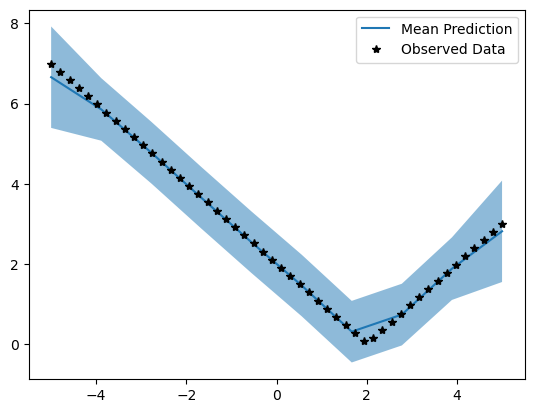

In [58]:
x = torch.linspace(-5, 5, 10)
with torch.no_grad():
    pred = model(x.unsqueeze(-1))
    lower, upper = pred.confidence_region()

plt.plot(x.numpy(), pred.mean.numpy(), label='Mean Prediction')
plt.fill_between(x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
plt.plot(train_x.numpy(), train_y.numpy(), 'k*', label='Observed Data')
plt.legend()
plt.show()

In [59]:
pred_mean = pred.mean.numpy()
param = x.numpy()
best_x = param[pred_mean.argmin()]
print(f'minimum of mean value function = {best_x}')
observed_min = train_x[train_y.argmin()]
print(f'observed minimum in data = {observed_min}')

minimum of mean value function = 1.6666665077209473
observed minimum in data = 1.9387754201889038
